# Environment Monitoring & Pollution Control — Complete Project
This notebook contains code for data loading, preprocessing, visualization, model training, evaluation, and saving the trained pipeline.

Place `air_quality_dataset.csv` in the same folder before running.

## Requirements
```bash
pip install pandas numpy matplotlib seaborn scikit-learn joblib
```

## 1. Imports & Load Data

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Load
df = pd.read_csv('air_quality_dataset.csv')
df.head()

,SITE_ID,Week,Year,DATEOFF,Ca,Cl,HNO3,HNO3 PPB,K,Mg,Na,NH4,NO3,SO2,SO2 PPB,SO4,TNO3,DATEON
0,ABT147,27,2023,7/11/2023 8:00:00 AM,0.042,0.032,0.759,0.295,0.129,0.022,0.055,0.279,0.088,0.258,0.098,0.915,0.834,7/04/2023
1,ABT147,28,2023,7/18/2023 8:00:00 AM,0.114,0.033,0.74,0.287,0.091,0.056,0.302,0.268,0.332,0.316,0.121,1.273,1.06,7/11/2023
2,ABT147,29,2023,7/25/2023 8:00:00 AM,0.062,0.033,0.648,0.251,0.074,0.02,0.07,0.276,0.128,0.294,0.112,0.705,0.766,7/18/2023
3,ABT147,30,2023,8/01/2023 8:00:00 AM,0.064,0.033,0.598,0.232,0.069,0.022,0.096,0.304,0.196,0.333,0.127,0.841,0.784,7/25/2023
4,ABT147,31,2023,8/08/2023 8:00:00 AM,0.059,0.176,0.348,0.135,0.065,0.033,0.208,0.366,0.382,0.331,0.126,0.596,0.724,8/01/2023


## 2. Quick inspection

In [6]:
print('Shape:', df.shape)
print(df.columns.tolist())
print(df.isna().sum().sort_values(ascending=False).head(20))

Shape: (2103, 18)
['SITE_ID', 'Week', 'Year', 'DATEOFF', 'Ca', 'Cl', 'HNO3', 'HNO3 PPB', 'K', 'Mg', 'Na', 'NH4', 'NO3', 'SO2', 'SO2 PPB', 'SO4', 'TNO3', 'DATEON']
SITE_ID     0
Week        0
Year        0
DATEOFF     0
Ca          0
Cl          0
HNO3        0
HNO3 PPB    0
K           0
Mg          0
Na          0
NH4         0
NO3         0
SO2         0
SO2 PPB     0
SO4         0
TNO3        0
DATEON      0
dtype: int64


## 3. Cleaning & conversion

In [7]:
numeric_cols = ['Ca','Cl','HNO3','HNO3 PPB','K','Mg','Na','NH4','NO3','SO2','SO2 PPB','SO4','TNO3']
for c in numeric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

if 'DATEOFF' in df.columns:
    df['DATEOFF'] = pd.to_datetime(df['DATEOFF'], errors='coerce')
if 'DATEON' in df.columns:
    df['DATEON'] = pd.to_datetime(df['DATEON'], errors='coerce')

print('Converted numeric and parsed dates')
df.head()

Converted numeric and parsed dates


,SITE_ID,Week,Year,DATEOFF,Ca,Cl,HNO3,HNO3 PPB,K,Mg,Na,NH4,NO3,SO2,SO2 PPB,SO4,TNO3,DATEON
0,ABT147,27,2023,2023-07-11 08:00:00,0.042,0.032,0.759,0.295,0.129,0.022,0.055,0.279,0.088,0.258,0.098,0.915,0.834,2023-07-04
1,ABT147,28,2023,2023-07-18 08:00:00,0.114,0.033,0.740,0.287,0.091,0.056,0.302,0.268,0.332,0.316,0.121,1.273,1.060,2023-07-11
2,ABT147,29,2023,2023-07-25 08:00:00,0.062,0.033,0.648,0.251,0.074,0.020,0.070,0.276,0.128,0.294,0.112,0.705,0.766,2023-07-18
3,ABT147,30,2023,2023-08-01 08:00:00,0.064,0.033,0.598,0.232,0.069,0.022,0.096,0.304,0.196,0.333,0.127,0.841,0.784,2023-07-25
4,ABT147,31,2023,2023-08-08 08:00:00,0.059,0.176,0.348,0.135,0.065,0.033,0.208,0.366,0.382,0.331,0.126,0.596,0.724,2023-08-01


## 4. Feature engineering

In [8]:
if 'DATEOFF' in df.columns:
    df['year'] = df['DATEOFF'].dt.year
    df['month'] = df['DATEOFF'].dt.month
    df['weekday'] = df['DATEOFF'].dt.weekday
    df['weekofyear'] = df['DATEOFF'].dt.isocalendar().week.astype(int)
    print('Added date features')
else:
    print('DATEOFF not present')

Added date features


## 5. Visualizations (quick)

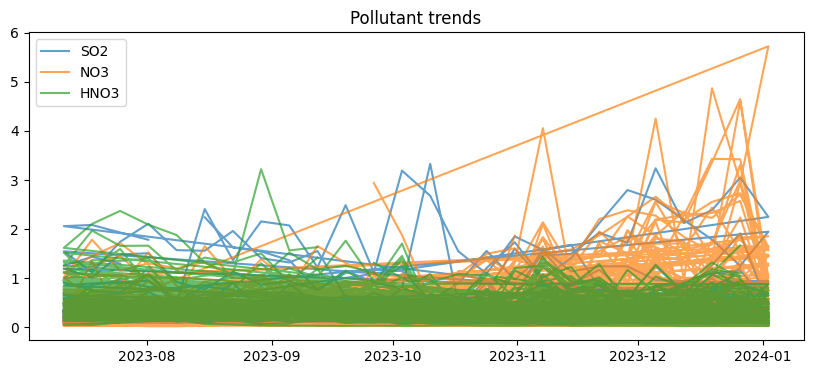

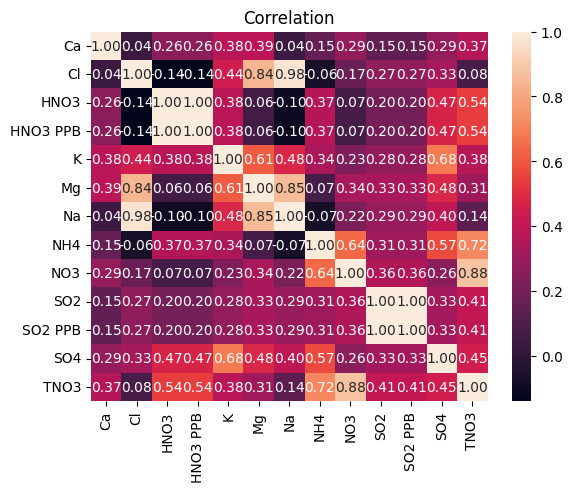

In [9]:
# Time series for chosen pollutants
plt.figure(figsize=(10,4))
for p in ['SO2','NO3','HNO3']:
    if p in df.columns:
        plt.plot(df['DATEOFF'], df[p], label=p, alpha=0.7)
plt.legend(); plt.title('Pollutant trends'); plt.show()

# Correlation heatmap
present = [c for c in numeric_cols if c in df.columns]
if present:
    sns.heatmap(df[present].corr(), annot=True, fmt='.2f'); plt.title('Correlation'); plt.show()

## 6. Preprocessing & Modeling

In [10]:
TARGET = 'SO2'
if TARGET not in df.columns:
    raise ValueError('SO2 not found')

df_model = df.dropna(subset=[TARGET]).copy()
exclude = [TARGET,'DATEOFF','DATEON']
features = [c for c in df_model.columns if c not in exclude]

numeric_features = [c for c in features if c in numeric_cols or df_model[c].dtype in [np.float64, np.int64]]
numeric_features = [c for c in numeric_features if c != TARGET]
categorical_features = [c for c in features if c not in numeric_features]

print('Numeric:', numeric_features)
print('Categorical:', categorical_features)

numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
cat_transformer = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
preprocessor = ColumnTransformer([('num', numeric_transformer, numeric_features), ('cat', cat_transformer, categorical_features)])

X = df_model[numeric_features + categorical_features]
y = df_model[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

pipe_lr = Pipeline([('preprocessor', preprocessor), ('regressor', LinearRegression())])
pipe_rf = Pipeline([('preprocessor', preprocessor), ('regressor', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))])

print('Fitting Linear Regression...')
pipe_lr.fit(X_train,y_train)
print('Fitting Random Forest...')
pipe_rf.fit(X_train,y_train)
print('Done')

Numeric: ['Week', 'Year', 'Ca', 'Cl', 'HNO3', 'HNO3 PPB', 'K', 'Mg', 'Na', 'NH4', 'NO3', 'SO2 PPB', 'SO4', 'TNO3', 'weekofyear']
Categorical: ['SITE_ID', 'year', 'month', 'weekday']
Fitting Linear Regression...
Fitting Random Forest...
Done


## 7. Evaluation

Linear Regression:
LinearRegression RMSE: 0.0008, R2: 1.0000


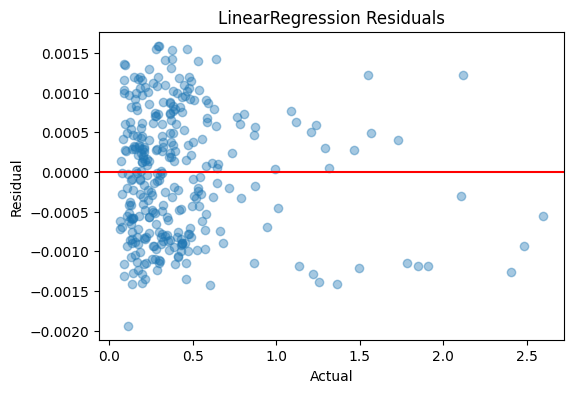

Random Forest:
RandomForest RMSE: 0.0131, R2: 0.9989


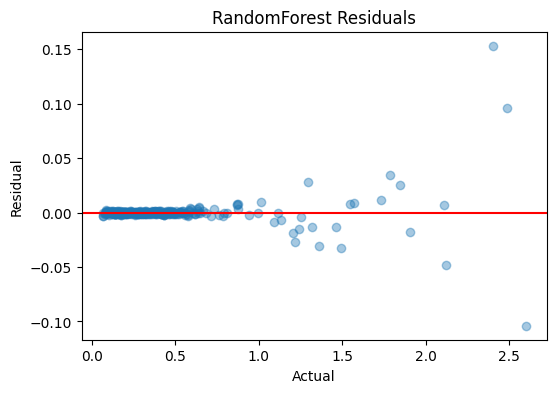

In [11]:
def evaluate(model, X_test, y_test, name='model'):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{name} RMSE: {rmse:.4f}, R2: {r2:.4f}")
    plt.figure(figsize=(6,4))
    plt.scatter(y_test, y_test - y_pred, alpha=0.4)
    plt.axhline(0, color='red')
    plt.xlabel('Actual'); plt.ylabel('Residual'); plt.title(f'{name} Residuals')
    plt.show()

print('Linear Regression:')
evaluate(pipe_lr, X_test, y_test, 'LinearRegression')
print('Random Forest:')
evaluate(pipe_rf, X_test, y_test, 'RandomForest')

## 8. Save model
The trained Random Forest pipeline (including preprocessing) is saved for reuse.

In [12]:
joblib.dump(pipe_rf, 'so2_pipeline_rf.joblib')
print('Saved so2_pipeline_rf.joblib')

Saved so2_pipeline_rf.joblib


## Project Summary
**Learning Objectives:** Monitor and analyze air quality, preprocess data, build ML models, evaluate and deploy.

**Methodology (short):** Preprocess → EDA → Model → Evaluate → Save.

**Problem Statement:** Predict SO₂ to support pollution control.

**Conclusion:** A reusable pipeline was created to predict pollutant levels and support decision-making.